In [2]:
import cv2
import pytesseract
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import pytesseract

* 함수

In [3]:
# 이미지 출력 함수
def imshow(img, size=(15, 8)):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=size)
    plt.imshow(img)
    plt.show()

# 이미지 전체 테두리 지우기, 경계선 검출시 필요
def draw_edge(img, margin=1):
    img[0:margin, :], img[-margin:, :], img[:, 0:margin], img[:, -margin:] = 255, 255, 255, 255
    return img

* 데이터불러오기

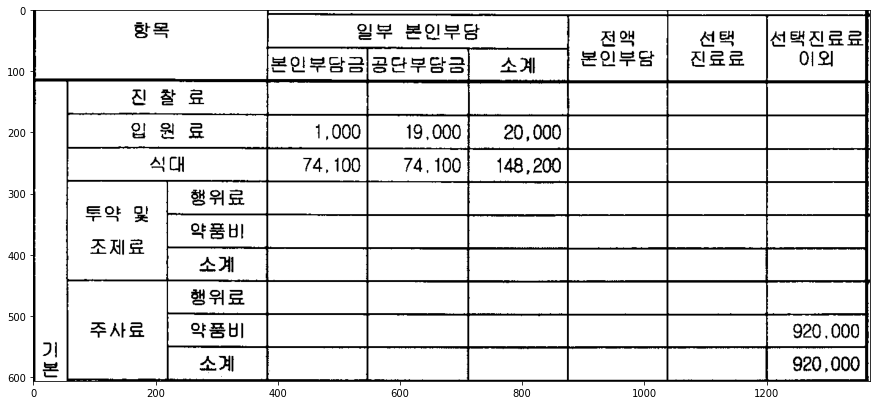

In [4]:
# PARAMETERS
path = '../img/'            # 원본이미지 경로
proc_path = '../proc_img/'  # 이진화 후 이미지 경로
cell_path = '../cell_img/'  # 셀구역을 표현한 이미지
split_path = '../sp_img/'   # 셀단위로 쪼개진 이미지
filename = 'image02.png' # 파일명

img = cv2.imread(path+filename, cv2.IMREAD_GRAYSCALE)  # 이미지 불러오기

# 이진화
bi_thr = 190
ret, bi_img = cv2.threshold(img, bi_thr, 255, cv2.THRESH_BINARY)

imshow(bi_img)

* 직선검출

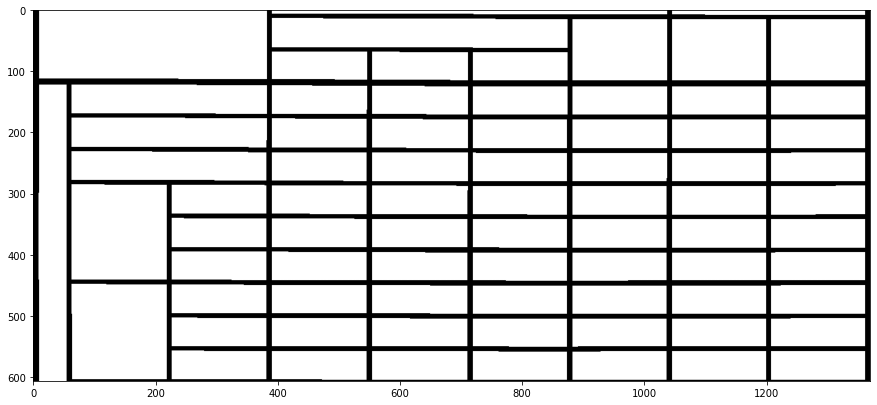

In [5]:
# kernel_erode = np.ones((3, 3), np.uint8)
# erotion = cv2.erode(bi_img, kernel_erode, iterations=3)

kernel_del_row = np.ones((1, 30), np.uint8)
kernel_del_col = np.ones((30, 1), np.uint8)

kernel_ext_row = np.ones((2, 30), np.uint8)
kernel_ext_col = np.ones((30, 2), np.uint8)

dilation_row = cv2.dilate(bi_img, kernel_del_row, iterations=5)
dilation_col = cv2.dilate(bi_img, kernel_del_col, iterations=6)

dilation_row = cv2.erode(dilation_row, kernel_ext_row, iterations=5)
dilation_col = cv2.erode(dilation_col, kernel_ext_col, iterations=6)

imshow(cv2.min(dilation_row, dilation_col))

* 라인제거(오래걸림)

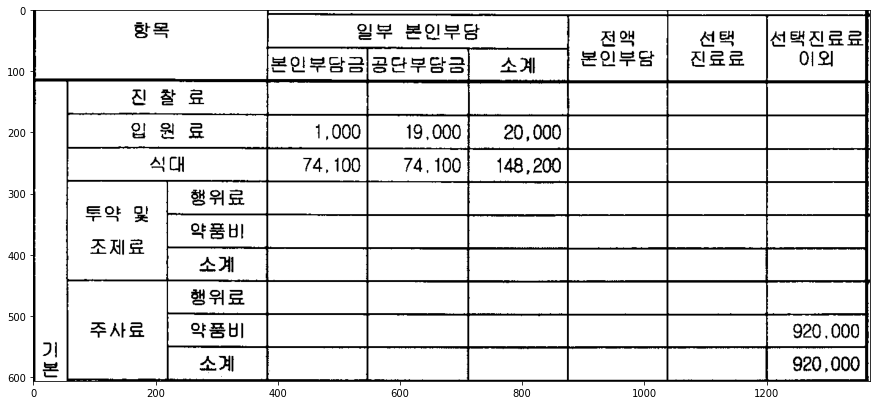

In [6]:
rm_line_img = copy.deepcopy(bi_img)
for row_id in range(dilation_row.shape[0]):
    for col_id in range(dilation_row.shape[1]):
        if dilation_row[row_id, col_id] == 0:
            rm_line_img[row_id, col_id: col_id ] = 255
        if dilation_col[row_id, col_id] == 0:
            rm_line_img[row_id: row_id, col_id] = 255
imshow(rm_line_img)

* 텍스트 영역 검출

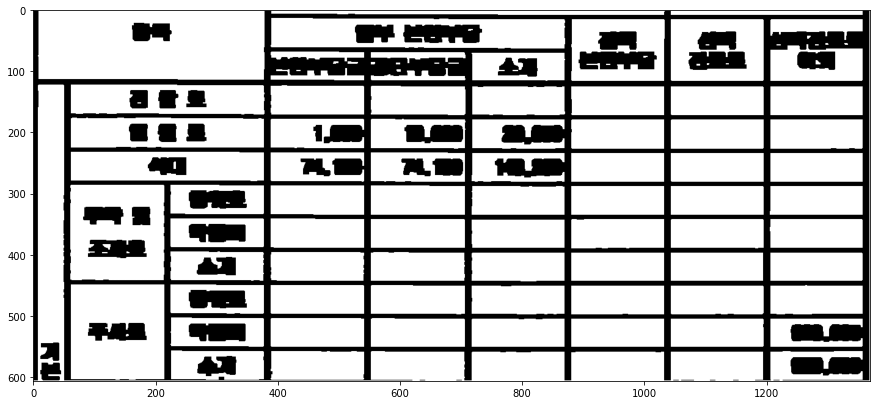

In [7]:
erod_text = np.ones((2, 3) , np.uint8)
dilate_text = np.ones((2, 3) , np.uint8)

er_text_img = cv2.erode(rm_line_img, erod_text, iterations=5)
er_text_img = cv2.dilate(er_text_img, dilate_text, iterations=1)
# er_text_img = cv2.erode(er_text_img, erod_text, iterations=2)
# er_text_img = cv2.dilate(er_text_img, dilate_text, iterations=2)

er_text_img = draw_edge(er_text_img, margin=1)  # 이미지 가장자리 흰색으로 칠함
imshow(er_text_img)

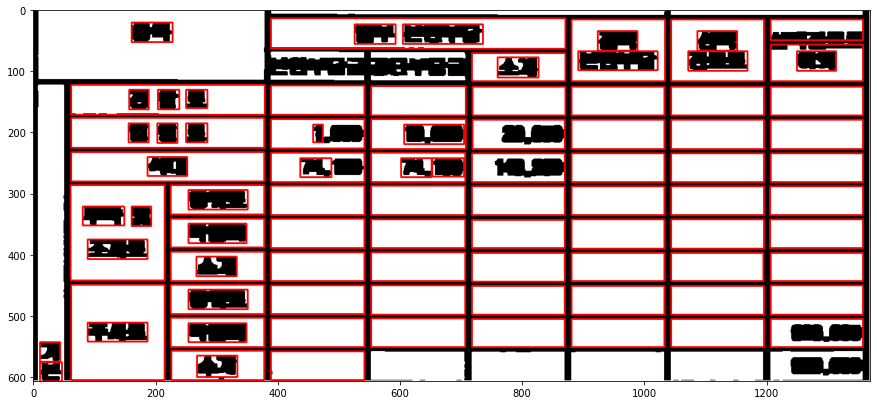

In [8]:
# get text box
back_img = cv2.cvtColor(er_text_img, cv2.COLOR_GRAY2RGB)  # 배경이미지
cnt_text, hier = cv2.findContours(er_text_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
text_area_list = list()
for cnt in cnt_text:
    x, y, w, h = cv2.boundingRect(cnt)
    # 전체 박스 제외
    if (20 < h < back_img.shape[0]-10):
        cv2.rectangle(back_img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        text_area_list.append((x, y, x+w, y+h))
        
back_img = cv2.cvtColor(back_img, cv2.COLOR_BGR2RGB)
imshow(back_img)

* 라인, 셀 생성

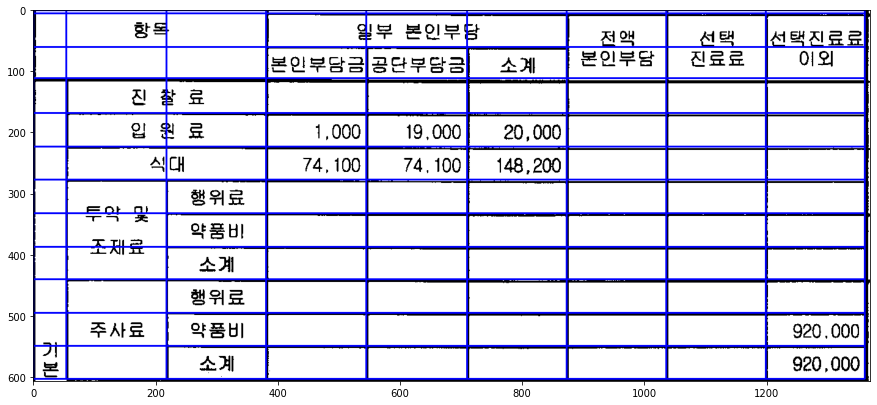

In [9]:
# 라인생성
line_x, line_y = list(), list()  # 라인 좌표
dilation_row = draw_edge(dilation_row)
dilation_col = draw_edge(dilation_col)

cnt_row, hierarchy = cv2.findContours(dilation_row, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnt_col, hierarchy = cv2.findContours(dilation_col, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

for cnt in cnt_row:
    x, y, w, h = cv2.boundingRect(cnt)
    if w > 30:
        line_y.append(y)
for cnt in cnt_col:
    x, y, w, h = cv2.boundingRect(cnt)
    if h > 30:
        line_x.append(x)

line_x = sorted(line_x)
line_y = sorted(line_y)

# 셀 생성
cell_dict = dict()
cell_list = list()

for n_x, x in enumerate(line_x):
    if n_x == len(line_x) - 1:
        pass
    else:
        for n_y, y in enumerate(line_y):
            if n_y == len(line_y) - 1:
                pass
            else:
                coord = (x, y, line_x[n_x+1], line_y[n_y+1])
                cell_list.append(coord)
                cell_dict[coord] = (n_x, n_y)
# cell 확인
back_img = cv2.cvtColor(rm_line_img,cv2.COLOR_GRAY2RGB)

for cell_coord in cell_list:
    cv2.rectangle(back_img, (cell_coord[0], cell_coord[1]), (cell_coord[2], cell_coord[3]), (255, 0, 0), 2)
imshow(back_img)

* 텍스트 추출(오래걸림)

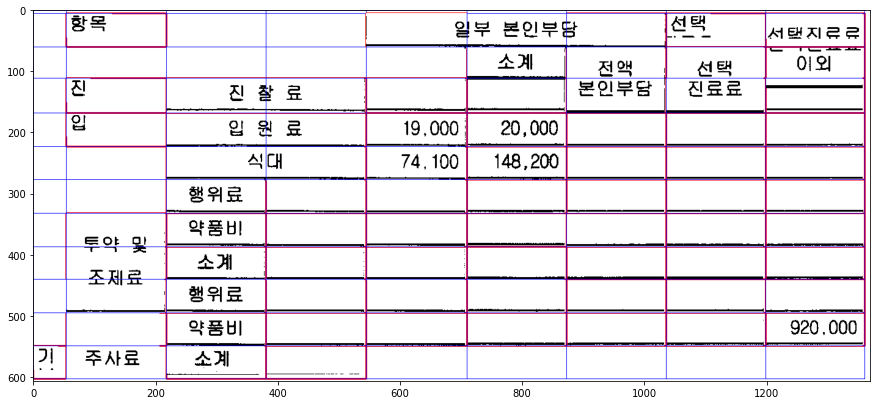

,0,1,2,3,4,5,6,7,8,9
0,,,,,,,,,,
1,,,항목,,,일부ㅣ 일부 본인부담본인부담,,전액,선택,시이 히구우
2,,,,,,,소계소계,본인부담아흐,쁘진료료,이외- 이외 -
3,,,진,진찰료찰료,00,0000,000,000,,0
4,,,입,원0 일 원료료,1.0091,19.00019.000,20.000,0,000,0
5,,,,식대이 00 적대 0,"74,74.10","74,74.10100",148.200,-…,,0
6,,,,： 행위료행위료,,,00,,,00000
7,,,투약대뒷,약품비_ 약품비,,,,0000,000,0
8,,,조제료,소계- 소계,,,,0000,000,000
9,,,,_ 행위료행위료,,,,-…,,000


In [10]:
# 배경이미지
back_img = copy.deepcopy(rm_line_img)
back_img[:, :] = 255  # 흰색
back_img = cv2.cvtColor(back_img, cv2.COLOR_GRAY2RGB)

custom_oem_psm_config = r'--oem 1 --psm 8'
text_cell_list = list()

for text_coord in text_area_list:
    t_x1, t_y1, t_x2, t_y2 = text_coord       # 텍스트 좌표 추출
    text_mid = ((t_x1+t_x2)/2, (t_y1+t_y2)/2) # 텍스트 중간 좌표 추출
    mar = 4                                   # 텍스트 마진
    if (t_x2 + mar > rm_line_img.shape[1]) | (t_y2 + mar > rm_line_img.shape[0]) | (t_x1 - mar < 0) | (t_y1 - mar < 0):
        # 마진을 포함한 텍스트 영역이 이미지 전체 크기를 벗어날 때
        text_img = cv2.cvtColor(rm_line_img[t_y1:t_y2, t_x1:t_x2], cv2.COLOR_GRAY2RGB)
        text = pytesseract.image_to_string(text_img, lang = 'kor', config=custom_oem_psm_config)
    else:
        text_img = cv2.cvtColor(rm_line_img[t_y1 - mar :t_y2 + mar, t_x1 - mar :t_x2 + mar], cv2.COLOR_GRAY2RGB)
        text = pytesseract.image_to_string(text_img, lang = 'kor', config=custom_oem_psm_config) 
    w, h =  text_img.shape[1], text_img.shape[0]  # 텍스트 영역 크기
    
    for cell_coord in cell_list:
        c_x1, c_y1, c_x2, c_y2 = cell_coord  # 셀좌표(좌상단, 우하단)
        if (c_x1 < text_mid[0] <c_x2) & (c_y1 < text_mid[1] < c_y2):
            # 텍스트 중간지점이 셀 영역 안에 있을 때
            cv2.rectangle(back_img, (c_x1, c_y1), (c_x2, c_y2), (0, 0, 255), 2)  # 셀 영역 붉은색으로 테두리
            area = back_img[c_y1: c_y1+h, c_x1: c_x1+w]  # 텍스트 영역
            if area.shape[0] < text_img.shape[0]:
                # 셀 영역이 텍스트 영역보다 작을 때
                diff = text_img.shape[0] - area.shape[0]
                back_img[c_y1: c_y1+h, c_x1: c_x1+w] = text_img[:-diff, :]
            elif area.shape[1] < text_img.shape[1]:
                diff = text_img.shape[1] - area.shape[1]
                back_img[c_y1: c_y1+h, c_x1: c_x1+w] = text_img[:, :-diff]
            else:
                # 배경 이미지 내 셀 좌표를 텍스트로 표시
                back_img[c_y1: c_y1+h, c_x1: c_x1+w] = text_img
            
            cell = cell_dict[cell_coord]                   # 셀 테이블 좌표 (행, 열)
            text_cell_list.append((text, cell, text_mid))  # 텍스트, 테이블 좌표, 텍스트 중심 좌표 추출
            
            sp_filename = filename.split('.')[0] + '_(' + str(cell[1]) + ',' + str(cell[0]) + ')_' + str(text_coord)  + '_.' + filename.split('.')[1]
            cv2.imwrite(split_path+sp_filename, text_img)  # 파일 저장

        else:
            # 텍스트 영역이 아니면 파란색으로 테두리 칠함
            cv2.rectangle(back_img, (c_x1, c_y1), (c_x2, c_y2), (255, 0, 0), 1)
            
cv2.imwrite('cell_img/'+filename, back_img)
imshow(back_img)


table = np.chararray(shape=(len(line_y)-1, len(line_x)-1), itemsize=30, unicode=True)  # 테이블 초기화
text_cell_list_sorted = sorted(text_cell_list, key=lambda tup: tup[2][0])  # 텍스트 중심좌표의 x 좌표 기준으로 정렬

for text_tup in text_cell_list_sorted:
    text, pos, mid_coord = text_tup
    table[pos[1], pos[0]] += text
table_df = pd.DataFrame(table)
display(table_df)

* 인식결과 표형태로 배열

In [11]:
table = np.chararray(shape=(len(line_y)-1, len(line_x)-1), itemsize=30, unicode=True)  # 테이블 초기화

cell_coord_dict = {cell_coord: list() for text, cell_coord, text_coord in text_cell_list_sorted}

for text_cell in text_cell_list_sorted:
    text, cell_coord, text_mid_coord = text_cell
    cell_coord_dict[cell_coord].append((text, text_mid_coord))

# 정렬
for cell_coord, text_list in cell_coord_dict.items():
    if len(text_list) >= 2:
        # 셀 안에 텍스트가 두개 이상 있을 경우
        sorted_text_list = sorted(text_list, key=lambda tup: tup[1][0])
        # 맨 처음 텍스트에 비해 y값이 20이상 차이날 경우 맨 뒤로 보냄
        for i in range(len(sorted_text_list)):
            if sorted_text_list[i][1][1] - sorted_text_list[0][1][1] > 20:
                pop = sorted_text_list.pop(i)
                sorted_text_list.append(pop)
        cell_coord_dict[cell_coord] = sorted_text_list
    else:
        # 셀 안에 텍스트가 하나일 경우
        table[cell_coord[1], cell_coord[0]] = text_list[0][0]
        
for coord, text_list in cell_coord_dict.items():
    text = ''.join([str_ for str_, coord in text_list])
    table[coord[1], coord[0]] = text
    
pd.DataFrame(table)

,0,1,2,3,4,5,6,7,8,9
0,,,,,,,,,,
1,,,항목,,,일부ㅣ 일부 본인부담본인부담,,전액,선택,시이 히구우
2,,,,,,,소계소계,본인부담아흐,쁘진료료,이외- 이외 -
3,,,진,진찰료찰료,00,0000,000,000,,0
4,,,입,원0 일 원료료,1.0091,19.00019.000,20.000,0,000,0
5,,,,식대이 00 적대 0,"74,74.10","74,74.10100",148.200,-…,,0
6,,,,： 행위료행위료,,,00,,,00000
7,,,투약뒷대,약품비_ 약품비,,,,0000,000,0
8,,,조제료,소계- 소계,,,,0000,000,000
9,,,,_ 행위료행위료,,,,-…,,000


In [21]:
split_path

'../sp_img/'

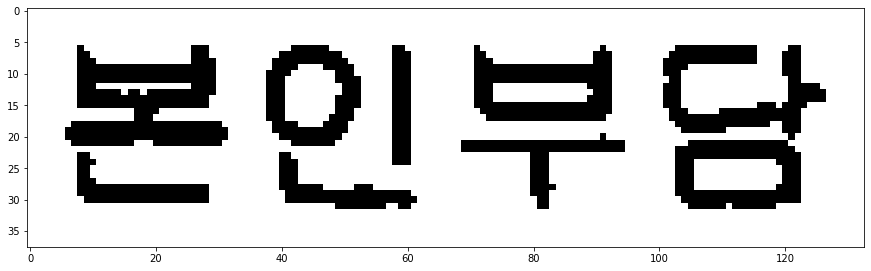

In [23]:
img = cv2.imread(split_path+'image02(0, 4)_(604, 17, 737, 55).png')
imshow(img)

In [24]:
pytesseract.image_to_string(img, lang = 'kor', config=custom_oem_psm_config)

'본인부담'